<a href="https://colab.research.google.com/github/MinsooKwak/image_caption/blob/main/image_caption_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

이미지 처리를 위해서는 CNN 계열의 모델, 자연어 처리를 위해서는 RNN계열의 모델을 활용해 이미지를 캡션할 수 있다. 

최근 Transformer 기반의 모델들이 대두되고 SOTA를 기록하고 있는 것을 볼 수 있다. 

CNN 계열의 backbone을 고민하기에 앞서 이미지 처리에도 transformer를 활용한 ViT, SwinTransformer가 SOTA를 기록하고 있다. 

ViT가 이미지를 작은 patch들로 쪼개면서 많은 computational complexity를 기록함에 있어 SwinTrnaformer가 shifted window partitioning을 통해 window 내부에서만 patch들끼리 self-attention을 통해 ViT의 문제를 해결했지만, SwinTransformer의 경우 2021년 등장한 비교적 최신 모델이기 때문에 해당 프로젝트를 진행하기에는 추가적인 노력이 필요하다 생각되었다. 

이에 해당 프로젝트에서는 Attention을 이용한 이미지 캡셔닝을 진행해보고자한다.

# Image Captioning Project with Attention

**InceptionV3 + Attention**

In [1]:
# 경고를 무시합니다.
import warnings
warnings.filterwarnings("ignore")

google mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# For deeplearning
import tensorflow as tf
import keras

# 이미지 및 자연어 처리를 위해 import
from tensorflow.keras.utils import load_img
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm

# import models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

# for modeling
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input

# 파일 경로명을 통해 파일 리스트 뽑음
import glob
import os

In [5]:
root_directory = '/content/drive/MyDrive/ImageCaption/Data/flickr8k'

**이미지 정보 파악**

In [6]:
# directory에서 파일명 불러오기
for dirname, _, filenames in os.walk(root_directory):
  for filename in filenames:
    print(os.path.join(dirname, filename))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3136674757_57406c305c.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3134387513_ceb75bea0a.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3134585858_a8c3493ca5.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3136688093_568b053bdf.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3138433655_ea1d59e5b7.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3139876823_859c7d7c23.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3134644844_493eec6cdc.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3138746531_f6b816c126.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3139118874_599b30b116.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3136043366_b3f8607a0e.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/3135504530_0f4130d8f8.jpg
/content/drive/MyDrive/ImageCaption/Data/flickr8k/i

In [7]:
images = '/content/drive/MyDrive/ImageCaption/Data/flickr8k/images'
all_imgs = glob.glob(images + '/*.jpg', recursive=True)
print("Total images in dataset:{}".format(len(all_imgs)))

Total images in dataset:8091


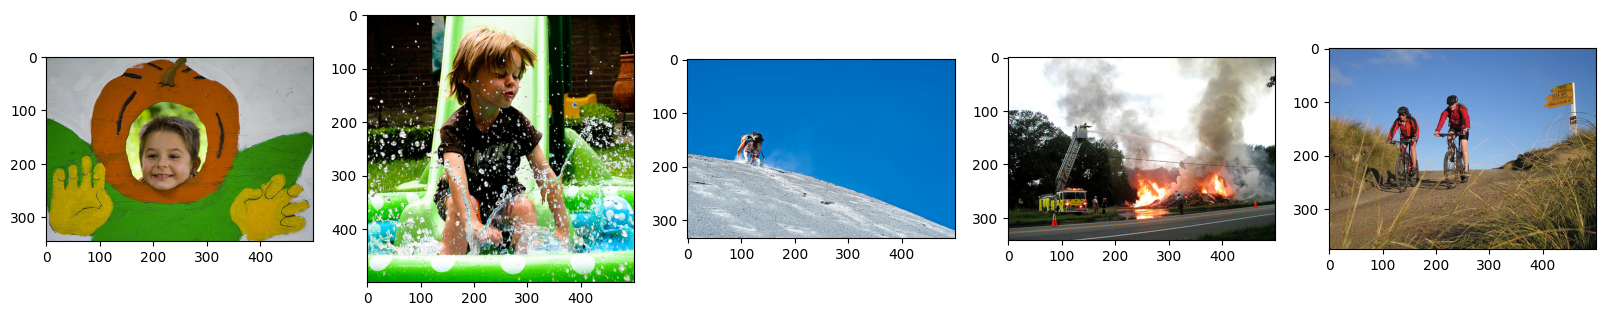

In [8]:
# image 불러오는 library (cv2가 속도가 더 빠름)
import imageio  

Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)

In [9]:
df = pd.read_csv('/content/drive/MyDrive/ImageCaption/Data/flickr8k/captions.txt')
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [10]:
df2 = pd.DataFrame(df.image.value_counts())
df2 = df2.reset_index()
df2

,index,image
0,1000268201_693b08cb0e.jpg,5
1,3388094307_5a83be64a5.jpg,5
2,3393394134_0caac47e1c.jpg,5
3,3393343330_b13df4d8ec.jpg,5
4,3393152604_27bd1037f2.jpg,5
...,...,...
8086,2699733386_c346c87ea6.jpg,5
8087,2699426519_228719b1db.jpg,5
8088,2699342860_5288e203ea.jpg,5
8089,2699125097_c6801d80ed.jpg,5


In [11]:
df2.image.value_counts()

5    8091
Name: image, dtype: int64

- 모든 이미지는 5개의 caption을 갖고 있음

In [12]:
img_path = '/content/drive/MyDrive/ImageCaption/Data/flickr8k/images/'
df['path'] = img_path+df['image']
df.head(3)

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/ImageCaption/Data/flick...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/MyDrive/ImageCaption/Data/flick...


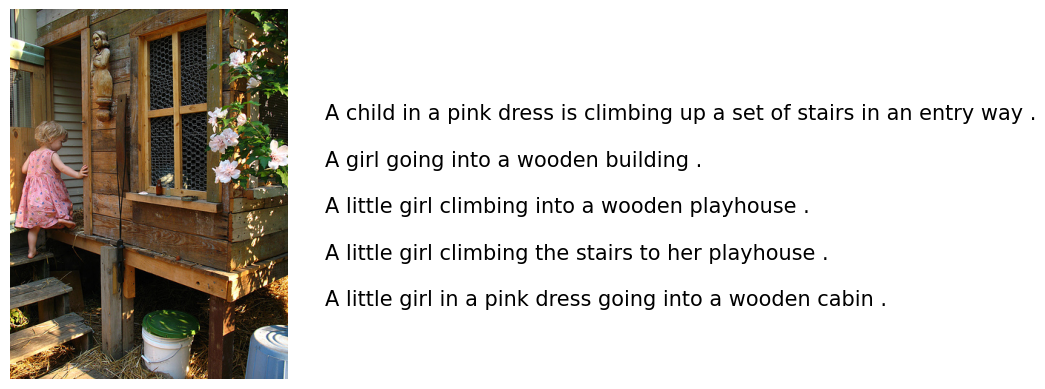

In [13]:
def caption_with_img(image_id, frame):
  capt = ('\n'*2).join(frame[frame['image'] == image_id].caption.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.image.to_list().index(image_id)
  im = Image.open(df.path.iloc[idx])
  width, height = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(width+50,height-100, capt, fontsize=15, color='black')

caption_with_img(df.image.iloc[3],df)

# Preprocessing

- 아래 불용어 처리 단계에서 발견한 전처리가 필요한 단어 처리를 진행

In [14]:
def word_prep(str):
  str = str.replace('coca','')
  str = str.replace('cola','coca-cola')
  str = str.replace('hapily','happily')
  str = str.replace('playy','play')
  str = str.replace('fronmt','front')
  str = str.replace('litle','little')
  str = str.replace('offf','off')
  str = str.replace('giong','going')
  str = str.replace('rakes','lakes')
  str = str.replace('sidwalk','sidewalk')
  str = str.replace('mommy','mom')
  str = str.replace('woamn','woman')
  str = str.replace('feamle','female')
  str = str.replace('matchin','matching')
  str = str.replace('jello','hello')
  str = str.replace('silohuetted','silhouetted')
  str = str.replace('redhead','red head')
  str = str.replace('ypoung','young')
  str = str.replace('unner','under')
  return str

In [15]:
df['caption'] = df['caption'].apply(word_prep)

In [16]:
def add_pad(str): 
  return '<start> '+str+' <end>'

In [17]:
df['caption_pad'] = df['caption'].apply(add_pad)
df.head(3)

,image,caption,path,caption_pad
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A little girl climbing into a wooden p...


## Tokeninzing

**영어 토큰화**

  > 특정한 구두점 문자를 대체하고 나머지 공백 문자를 기반으로 분할을 진행하는 keras tokenizer의 특성을 고려해 keras를 통한 토큰화 진행하기로 결정

- NLTK
  - 정규화 기반 (속도 빠름)
- spacy
  - 처리 속도는 NLTK, Keras 대비 낮으나 다른 성능 측면에서 우수
- **keras(text_to_word_sequence)**
  - 정규화 기반 (속도 빠름)
  - 모든 토큰을 소문자로 변경
  - Don't를 don't로 Jone's를 jone's로 변경 
  - 마침표나 쉼표 등의 구두점은 버림

**tf.keras.preprocessing.text 종류**
- hashing_trick
- one-hot
- text_to_word_sequence : text를 단어 순서나 토큰 순서로 반환
- Tokenizer : 사전에 있는 단어 순서 맞게 단어를 tuning하며 말뭉치를 벡터화, oov_token 통해 oov 대체


  ```
  from tensorflow.keras.preprocessing.text import text_to_word_sequence

  text = "Hello, world! This is an example sentence."
  words = text_to_word_sequence(text)
  print(words)

  -> output : ['hello', 'world', 'this', 'is', 'an', 'example', 'sentence']
  ```



  ```
  from tensorflow.keras.preprocessing.text import Tokenizer

  texts = ["Hello, world!", "This is an example sentence.", "Hello, again!"]
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(texts)
  sequences = tokenizer.texts_to_sequences(texts)
  word_index = tokenizer.word_index

  print(sequences)
  print(word_index)

  -> output:
  [[1, 2], [3, 4, 5, 6, 7], [1, 8]]
  {'hello': 1, 'world': 2, 'this': 3, 'is': 4, 'an': 5, 'example': 6, 'sentence': 7, 'again': 8}

  ```





In [18]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def token_word(string):
  '''
  token화 후 토큰들을 list로 return하는 함수 정의
  '''
  str_list = text_to_word_sequence(string)
  return str_list

In [19]:
df['token_list'] = df.caption.apply(token_word)
df['len'] = df.caption.apply(lambda x : len(x))

In [20]:
df.head(3)

,image,caption,path,caption_pad,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...,"[a, child, in, a, pink, dress, is, climbing, u...",72
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A girl going into a wooden building . ...,"[a, girl, going, into, a, wooden, building]",37
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A little girl climbing into a wooden p...,"[a, little, girl, climbing, into, a, wooden, p...",48


In [21]:
df.describe()

,len
count,40455.000000
mean,55.138154
std,18.841860
min,1.000000
25%,41.500000
50%,53.000000
75%,66.000000
max,199.000000


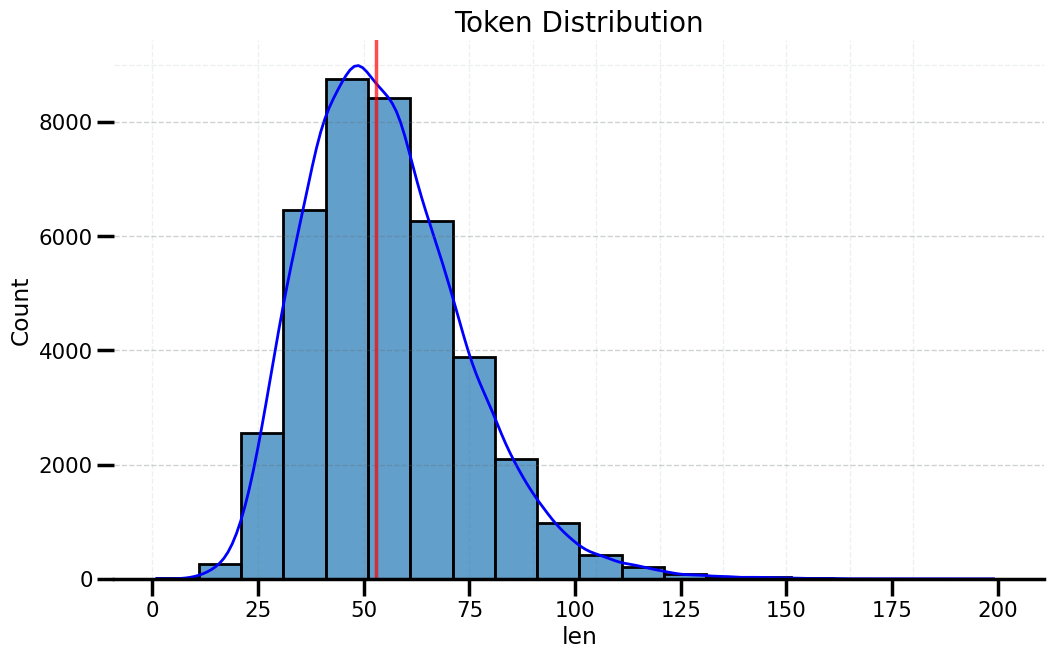

In [22]:
#sns.set_style('white',{'font.family':'NanumSquare'})
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig1, axes = plt.subplots(1,1, figsize=(12,7))
fig1.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig1.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig1.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax1 = sns.histplot(df, x='len', binwidth=10, alpha=0.7, kde=True,
                   line_kws={'lw':2} 
                   ## 'color':'b' 적용이 안되서 대안으로 아래 방식 활용
                   )
ax1.lines[0].set_color('b')
  
# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax1.set_title('Token Distribution', fontsize=20)

# y축 설정
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# x 축 설정
plt.axvline(x=0, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=25, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=50, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=75, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=90, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=105, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=120, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=135, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=150, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=165, color='#626774', linestyle='--', linewidth=1, alpha=0.1)
plt.axvline(x=180, color='#626774', linestyle='--', linewidth=1, alpha=0.1)

# 중위수 표시
plt.axvline(x=df['len'].median(), color='r', linestyle='-', linewidth=2.5, alpha=0.7)

## Dictionary 생성 및 불용어 제외

In [23]:
# tokenizer + embedding 가능 정의
word_dict_limit = 8000  # dict 크기 제한시 사용 # None 가능
tokenizer = Tokenizer(num_words = word_dict_limit+1, 
                      filters = '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, # 소문자 반환
                      char_level = False, # True일 경우 모든 문자 토큰으로 처리
                      oov_token = 'UNK')  # 지정시 text_to_sequence 호출 과정에 word_index에 추가되어 oov words 대체

In [24]:
df.head(1)

,image,caption,path,caption_pad,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...,"[a, child, in, a, pink, dress, is, climbing, u...",72


In [25]:
# word-to-index mapping
tokenizer.fit_on_texts(df['caption_pad'])

# embedding (integer)
train_seqs = tokenizer.texts_to_sequences(df['caption_pad'])

In [26]:
# PAD에 zero 더함
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [27]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [28]:
tokenizer.index_word

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog',
 11: 'with',
 12: 'man',
 13: 'of',
 14: 'two',
 15: 'white',
 16: 'black',
 17: 'boy',
 18: 'are',
 19: 'woman',
 20: 'girl',
 21: 'to',
 22: 'wearing',
 23: 'at',
 24: 'people',
 25: 'water',
 26: 'red',
 27: 'young',
 28: 'brown',
 29: 'an',
 30: 'his',
 31: 'blue',
 32: 'dogs',
 33: 'running',
 34: 'through',
 35: 'playing',
 36: 'while',
 37: 'shirt',
 38: 'down',
 39: 'standing',
 40: 'ball',
 41: 'little',
 42: 'grass',
 43: 'snow',
 44: 'child',
 45: 'person',
 46: 'jumping',
 47: 'over',
 48: 'front',
 49: 'three',
 50: 'sitting',
 51: 'holding',
 52: 'up',
 53: 'field',
 54: 'small',
 55: 'by',
 56: 'large',
 57: 'green',
 58: 'one',
 59: 'group',
 60: 'yellow',
 61: 'her',
 62: 'walking',
 63: 'children',
 64: 'men',
 65: 'into',
 66: 'air',
 67: 'beach',
 68: 'near',
 69: 'mouth',
 70: 'jumps',
 71: 'another',
 72: 'for',
 73: 'street',
 74: 'runs',
 75: 'its',
 7

- 추가적으로 확인 가능 요소 
> 추후 성능 확인 진행 후 token len과 성능 비교   

  - 유의미한지 
  - 영향이 있는지 상관분석

**Dictionary 생성 및 token 개수 파악**

> Counter 생성자를 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 저장된 객체를 얻어오겠다. 

In [29]:
# Counter 통해 중복된 데이터가 저장된 배열에서 각 원소가 몇 번씩 저장되었는지 확인
from collections import Counter

**형태소 단위 빈도 분석**

In [30]:
df.head(1)

,image,caption,path,caption_pad,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...,"[a, child, in, a, pink, dress, is, climbing, u...",72


In [31]:
combined_token_list = [i for tok_list in df['token_list'] for i in tok_list] # 하나의 리스트에 담음
print(len(combined_token_list))
# combined_token_list

437665


In [32]:
frequent = Counter(combined_token_list).most_common()
#print(f'unique한 token의 개수 : {len(words)}')
print(len(frequent))

8478


In [33]:
frequent[:5]

[('a', 62992), ('in', 18986), ('the', 18419), ('on', 10745), ('is', 9345)]

In [34]:
frequent_df = pd.DataFrame(frequent)
#frequent_df.sort_values(ascending=True)
frequent_df.head()

,0,1
0,a,62992
1,in,18986
2,the,18419
3,on,10745
4,is,9345


### remove stopwords

> **전처리 라이브러리** 
  - **OpenAI CLIP** : 
    - 이미지와 텍스트를 함께 입력 받아 벡터 변환
    - 불용어를 위한 텍스트 전처리 기능은 없음
    - 텍스트 데이터를 직접 조작할 수 있는 API 제공
    - 원하는 전처리 수행 가능
  - **NLP**:
    - NLTK, SpaCy, Gensim ...
  - **Custom Preprocessing**
    - 이미지와 텍스트 간 연관성 고려해 텍스트 처리 함수를 작성하고, 해당 함수를 활용에 불용어 제거 및 타 전처리 작업 수행 가능


- 해당 방식 중 **NLP 방식** 활용할 것

  - 불용어는 영향력이 없기 때문에 텍스트 처리를 진행하고 추후 모델을 통해 이미지와 텍스트의 관계성을 고려하려한다.
  > 활용 가능 라이브러리 : NLTK, SpaCy, Gensim ...
    - **Tensorflow + NLTK**
    - Tensorflow + SpaCy
    - **PyTorch + NLTK**
    - PyTorch + Gensim : 주로 토픽모델링, 단어 임베딩
  
  대표적인 NLTK를 활용하도록 하겠다.

In [35]:
import nltk
from nltk.corpus import stopwords

# 불용어 다운
nltk.download('stopwords')

# 불용어 집합에 담음
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
# NLTK 활용해 불용어 제거
# filtered_text = [w fo w in tokenized_text if w not in stop_words]

# 일단 2가지 처리 방식
## 1) 모델링에 stopword 처리된 것 활용 가능 -> filtered_token feature 생성
## 2) 위 불용어 집합 통해 리스트에서 불용어 처리

In [37]:
remove_stopwords = [x for x in combined_token_list if x not in stop_words]
frequent2 = Counter(remove_stopwords).most_common()
print(len(frequent2))

8360


In [38]:
frequent_df2 = pd.DataFrame(frequent2)
# 불용어 파악 위해 리스트 csv 저장
frequent_df2.to_csv('stopword_prepare.csv')

In [39]:
####### 보고 불용어 파악
## 숫자는 주요 정보일 수 있으므로 제거하지 않겠음
stopword2 = ['s',"'",'st','c','u','p','v','n','ac','ou',"n'",'gin','od','lav','kelp','nd','gren',
             'tbe','gith','dhe','h','la','osme','ot','djs','hte','fronr','ox','shire','hdr','rung',
             'boe','twp','vfw','ti','chi','tho','ont','mma','iove','ump','outise','lei','pf','ee',
             'thong','tge','ilks','r','floatlys','stucco','arc','brwon']

- 불용어 파악 단계에서 전처리 필요 단어들 발견
- 해당 내용은 토큰화 직전 부분에서 처리하는 것으로 순서 변경해 진행함
- 위 참조

In [40]:
def filter_tokens(string):
  string = [s for s in string if s not in stop_words]
  string = [s for s in string if s not in stopword2]
  return string

In [41]:
df.head(1)

,image,caption,path,caption_pad,token_list,len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...,"[a, child, in, a, pink, dress, is, climbing, u...",72


In [42]:
df['filtered_token']=df['token_list'].apply(filter_tokens)
df['filtered_len']=df['filtered_token'].apply(len)
df.head(2)

,image,caption,path,caption_pad,token_list,len,filtered_token,filtered_len
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A child in a pink dress is climbing up...,"[a, child, in, a, pink, dress, is, climbing, u...",72,"[child, pink, dress, climbing, set, stairs, en...",8
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/ImageCaption/Data/flick...,<start> A girl going into a wooden building . ...,"[a, girl, going, into, a, wooden, building]",37,"[girl, going, wooden, building]",4


(0.0, 9500.0)

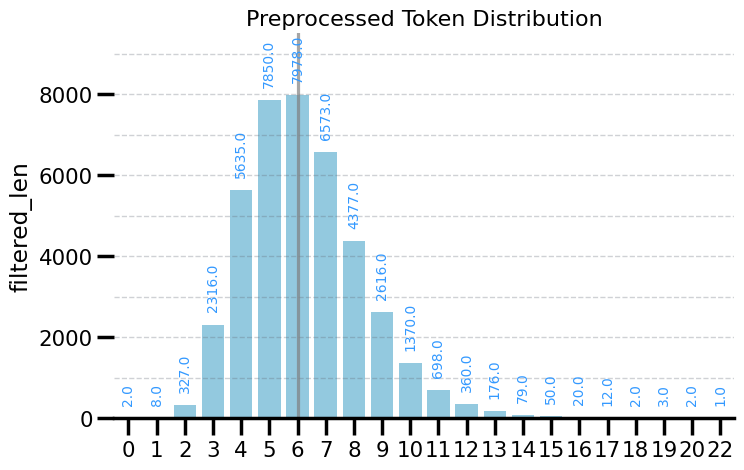

In [43]:
sns.set_context("poster", font_scale = 0.7, rc={"grid.linewidth": 5})

fig2, axes2 = plt.subplots(1,1, figsize=(8,5))
fig2.gca().spines['right'].set_visible(False)   # 오른쪽 테두리 제거
fig2.gca().spines['top'].set_visible(False)     # 위 테두리 제거
fig2.gca().spines['left'].set_visible(False)    # 왼쪽 테두리 제거

ax2 = sns.barplot(x=df['filtered_len'].value_counts().index, y=df['filtered_len'].value_counts(), color='skyblue')
  
# 값의 폭을 10단위로 확인해봄 # bins=n 통해 bin 개수 조절 가능
ax2.set_title('Preprocessed Token Distribution', fontsize=16)

# y축 설정
plt.axhline(y=1000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=2000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=3000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=4000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=5000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=6000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=7000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=8000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)
plt.axhline(y=9000, color='#626774', linestyle='--', linewidth=1, alpha=0.3)

# 중위수 표시
plt.axvline(x=df['filtered_len'].median(), color='gray', linestyle='-', linewidth=2.3, alpha=0.7)

for p in ax2.patches:
  height = p.get_height()
  ax2.text(p.get_x() + p.get_width()/2., height+400, height, ha='center', color='#3399FF', fontsize=10, rotation=90)
ax2.set_ylim(0,9500)

### 빈도어

In [44]:
# 하나의 리스트에 담음
filtered_token_list = [i for tok_list in df['filtered_token'] for i in tok_list]

# Top15 단어
freq = Counter(filtered_token_list).most_common()
filtered_freq_df = pd.DataFrame(freq)
filtered_freq_df.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,dog,man,two,white,black,boy,woman,girl,wearing,people,water,red,young,brown,blue
1,8138,7274,5642,3959,3848,3581,3403,3328,3062,2883,2790,2714,2630,2578,2279


### Pad vector to max_length caption

In [45]:
train_seqs_len = [len(seq) for seq in train_seqs]
max_word_length = max(train_seqs_len)

caption_vec = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                            padding='post',
                                                            maxlen=max_word_length,
                                                            dtype='int32',
                                                            value=0)

print(f'Caption vector shape : {caption_vec.shape}')

Caption vector shape : (40455, 39)


## Image Preprocessing

First Check

In [46]:
# check image format
tf.keras.backend.image_data_format()

'channels_last'

In [47]:
prep_img = []
IMAGE_SHAPE = (299, 299)

for img in all_imgs[0:5] :
  img = tf.io.read_file(img, name=None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  prep_img.append(img)

resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)
resized shape : (299, 299, 3)


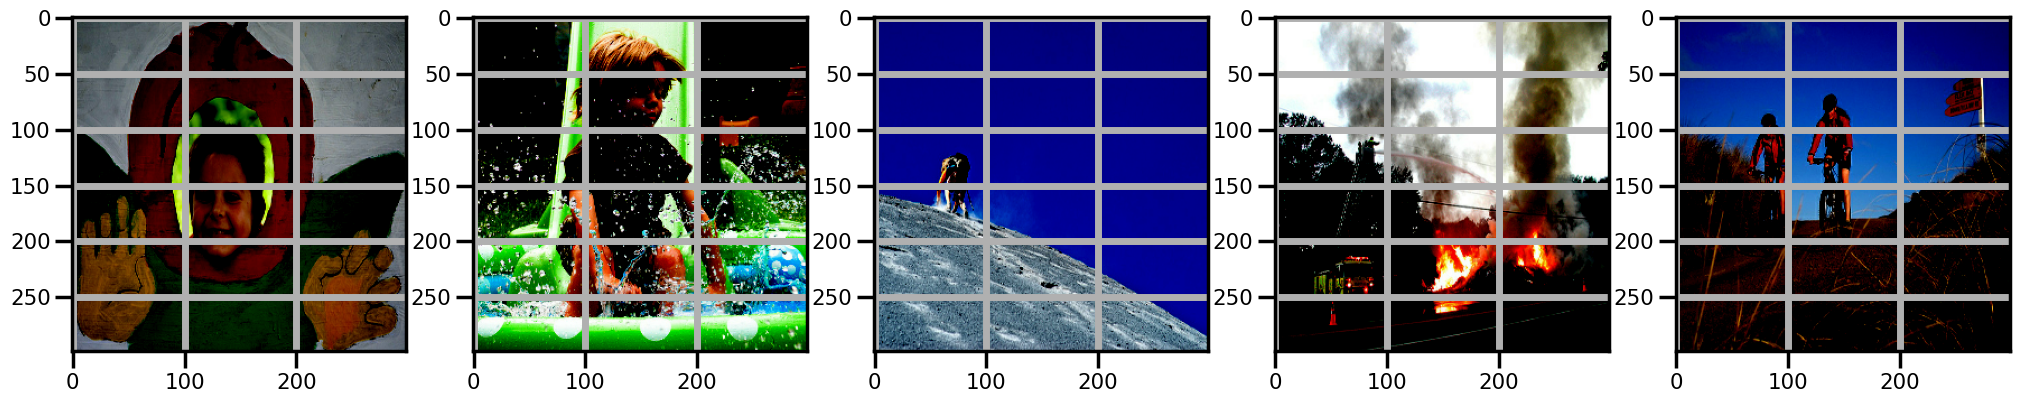

In [48]:
# check images post preprocessed
Display_Images = prep_img[0:5]
fig, axes = plt.subplots(1,5)
fig.set_figwidth(25)

for ax, image in zip(axes, Display_Images):
  print(f'resized shape : {image.shape}')
  ax.imshow(image)
  ax.grid('off')

**Processing Image**

In [49]:
def load_images(image_path):
  img = tf.io.read_file(image_path, name=None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [50]:
training_list = sorted(set(df['path']))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images,
                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [51]:
path_train, path_test, caption_train, caption_test = train_test_split(df['path'],
                                                                      caption_vec,
                                                                      test_size=0.2,
                                                                      random_state = 24)

print(f'Train data (images)  : {str(len(path_train))}')
print(f'Test  data (images)  : {str(len(path_test))}')
print(f'Train data (caption) : {str(len(caption_train))}')
print(f'Test  data (caption) : {str(len(caption_test))}')

Train data (images)  : 32364
Test  data (images)  : 8091
Train data (caption) : 32364
Test  data (caption) : 8091


# Modeling

## Load pretrained InceptionNetV3

In [52]:
image_model = tf.keras.applications.InceptionV3(include_top = False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
inceptionv3_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [53]:
inceptionv3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### Feature extracting

In [54]:
img_features = {}
for img, image_path in tqdm(New_Img):
  batch_features = inceptionv3_model(img)
  
  # squeeze features in batch
  flattened_feature = tf.reshape(batch_features, (batch_features.shape[0],-1, batch_features.shape[3]))

  for batch_feat, path in zip(flattened_feature, image_path):
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 127/127 [26:21<00:00, 12.46s/it]


In [55]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.74665326e-02, 0.00000000e+00, ...,
          2.31837019e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07787609e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94032162e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85755104e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42666084e-02, 0.00000000e+00, 5.05790770e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23005015e-01, 1.34471357e-02, ...,
          2.33669803e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [57]:
flattened_feature

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.00000000e+00, 7.74665326e-02, 0.00000000e+00, ...,
         2.31837019e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.07787609e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.94032162e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.85755104e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.65693688e+00, 0.00000000e+00],
        [0.00000000e+00, 4.02608901e-01, 0.00000000e+00, ...,
         0.00000000e+00, 3.17919135e-01, 0.00000000e+00],
        [0.00000000e+00, 2.53475714e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.25060153e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.84972608e-02, ...,
         1.20641959e+00, 0.

In [58]:
batch_feat.shape

TensorShape([64, 2048])